# Retrieval of a few parameters with Nested Sampling 

This example uses nested sampling. In archNEMESIS, nested sampling is done through the pyMultiNest package, which itself is a wrapper around the MultiNest code. Detailed instructions on installation can be found here: http://johannesbuchner.github.io/PyMultiNest/install.html

In [1]:
from archnemesis import *

Let's load in an example Neptune setup. 

In [2]:
runname = 'neptune'

#Reading the input files
Atmosphere,Measurement,Spectroscopy,Scatter,Stellar,Surface,CIA,Layer,Variables,Retrieval = read_input_files(runname)

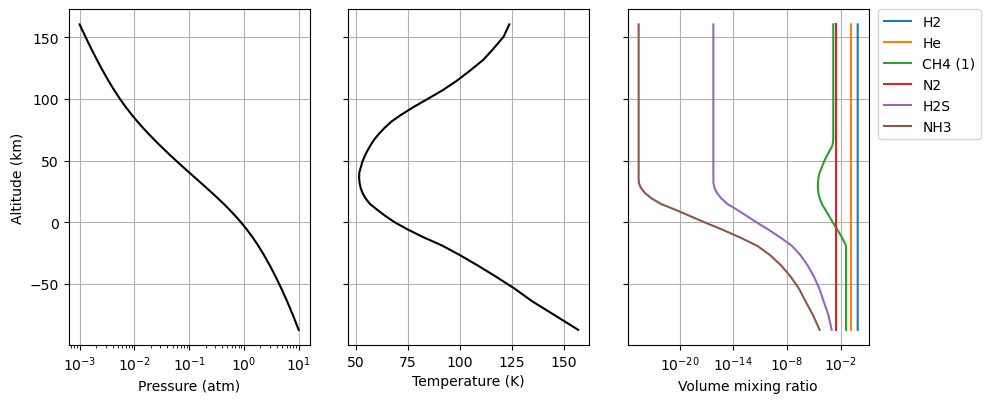

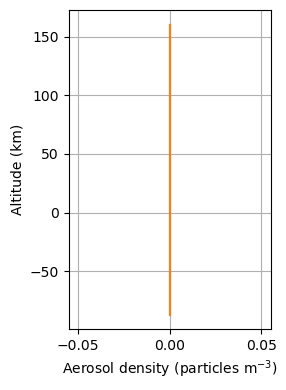

In [3]:
Atmosphere.plot_Atm()
Atmosphere.plot_Dust()

Atmosphere.DUST_UNITS_FLAG = [-1]*Atmosphere.DUST.shape[1]


We'll generate a spectrum, add some noise to it, and save it to our spx file. We're only using a small region of the spectrum for speed.

In [4]:
%%time
ForwardModel = ForwardModel_0(runname=runname, Atmosphere=Atmosphere,Surface=Surface,Measurement=Measurement,Spectroscopy=Spectroscopy,Stellar=Stellar,Scatter=Scatter,CIA=CIA,Layer=Layer,Variables=Variables)
SPECONV = ForwardModel.nemesisfm()

Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.0024492587068203
Maximum integral of phase function is  1.0029856636186842
CIRSrad :: Aerosol optical depths at  1.8490000175515888  ::  [0.37875526 0.        ]
CIRSrad :: Performing multiple scattering calculation
CIRSrad :: NF =  6 ; NMU =  5 ; NPHI =  100
CPU times: user 16.4 s, sys: 431 ms, total: 16.8 s
Wall time: 16.7 s


In [5]:
new_spectrum = SPECONV * np.random.normal(1,0.02,SPECONV.shape)
new_spectrum_error = new_spectrum*0.02

Measurement.MEAS[:,0] = new_spectrum
Measurement.ERRMEAS[:,0] = new_spectrum_error

        
#Not actually saving, so saved nested sampling results are still valid
# Measurement.write_spx()

        

Now, let's reload, with our new slightly noisy spectrum. We're keeping the apr file the same. This means that if we were running optimal estimation, we would start at the optimal point and the retrieval would end quickly. However, because nested sampling draws randomly from the prior distribution, it will still fully explore the space defined in the apr file.

In [6]:
Atmosphere,Measurement,Spectroscopy,Scatter,Stellar,Surface,CIA,Layer,Variables,Retrieval = read_input_files(runname)

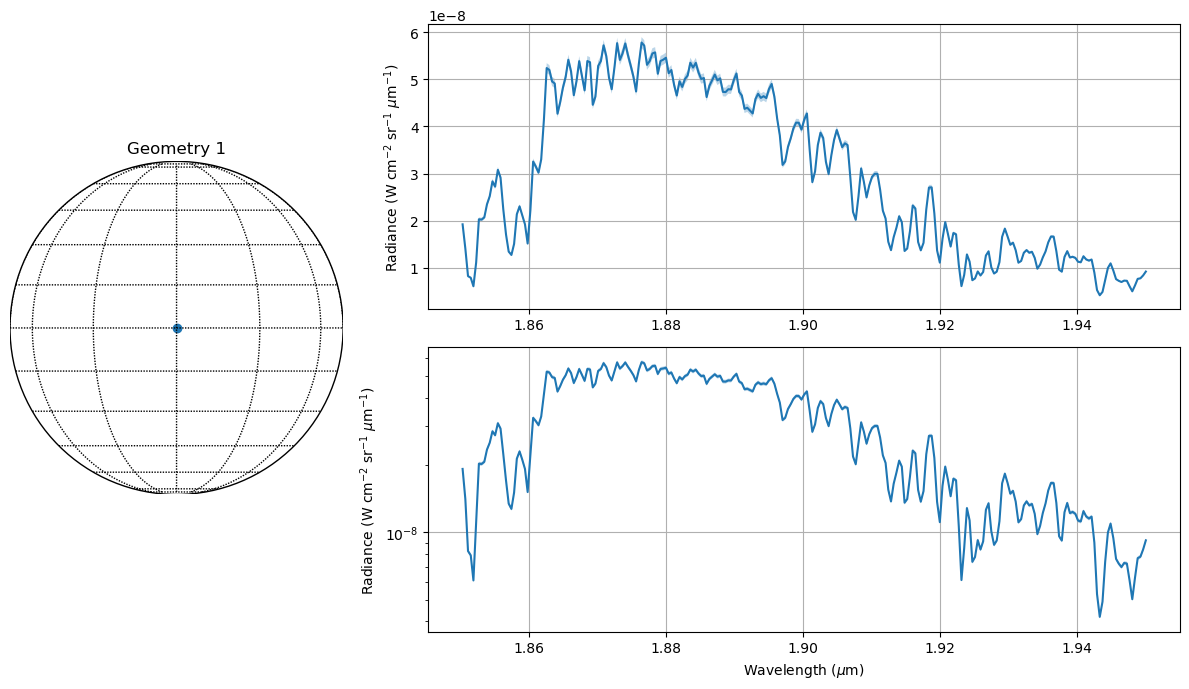

In [19]:
Measurement.plot_nadir()

Now let's run our nested sampling. This would usually take a long time (~40 minutes for me), but this example folder already contains the results from a previous run, so we can just investigate the output.

In [8]:
import subprocess

legacy_files=True  
retrieval_method=1  #Nested Sampling
NCores=30        

subprocess.run(["mpiexec", "-np", str(NCores), "python", "-c", 
                f"import archnemesis as ans; ans.Retrievals.retrieval_nemesis('{runname}', legacy_files={legacy_files}, retrieval_method={retrieval_method}, NCores={NCores})"])



 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    3
 resuming from previous job
 *****************************************************
 Starting MultiNest
Acceptance Rate:                        0.505920
Replacements:                               3931
Total Samples:                              7770
Nested Sampling ln(Z):               -119.706506
Importance Nested Sampling ln(Z):    -119.794794 +/-  0.073413
 ln(ev)=  -119.41738389222705      +/-  0.12783258525578428     
 Total Likelihood Evaluations:         7770
 Sampling finished. Exiting MultiNest
  analysing data from chains/.txt
  analysing data from chains/.txt
Creating marginal plot ...
Model run OK
 Elapsed time (s) = 2.5007145404815674
  analysing data from chains/.txt
  analysing data from chains/.txt
Creating marginal plot ...
Model run OK
 Elapsed time (s) = 2.490624189376831
  analysing data fr

CompletedProcess(args=['mpiexec', '-np', '30', 'python', '-c', "import archnemesis as ans; ans.Retrievals.retrieval_nemesis('neptune', legacy_files=True, retrieval_method=1, NCores=30)"], returncode=0)

Let's also do an optimal estimation run and compare. This should be quick.

In [9]:
legacy_files=True    
retrieval_method=0  
NCores=4
ans.Retrievals.retrieval_nemesis(runname,legacy_files=legacy_files,retrieval_method=retrieval_method,NCores=NCores)

nemesis :: Calculating Jacobian matrix KK
Calculating numerical part of the Jacobian :: running 4 forward models 
Calculating forward model 1/4
Calculating forward model 3/4
Calculating forward model 4/4
Calculating forward model 2/4
Calculated forward model 1/4
Calculated forward model 4/4
Calculated forward model 3/4
Calculated forward model 2/4
nemesis :: Calculating gain matrix
nemesis :: Calculating cost function
calc_phiret: phi1, phi2 = 328.08172199802243, 0.0)
chisq/ny = 1.2967656995969266
Assess:
Average of diagonal elements of Kk*Sx*Kt : 9.594884787809242e-18
Average of diagonal elements of Se : 4.686677258343464e-19
Ratio = 20.47268087583359
Average of Kk*Sx*Kt/Se element ratio : 25.624506543596524
******************* ASSESS WARNING *****************
Insufficient constraint. Solution likely to be exact
****************************************************
nemesis :: Iteration 0/10
nemesis :: Calculating next iterated state vector
Normalisation of phase function should be 1.0


Let's compare these two results.

In [10]:
lat,lon,ngeom,ny,wave,specret,specmeas,specerrmeas,nx,Var,aprprof,aprerr,retprof,reterr = ans.Files.read_mre('neptune')

In [11]:
from archnemesis.NestedSampling_0 import coreretNS

NestedSampling = coreretNS(runname,Variables,Measurement,Atmosphere,Spectroscopy,Scatter,Stellar,Surface,CIA,Layer)



 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    3
 resuming from previous job
 *****************************************************
 Starting MultiNest
Acceptance Rate:                        0.505920
Replacements:                               3931
Total Samples:                              7770
Nested Sampling ln(Z):               -119.706506
Importance Nested Sampling ln(Z):    -119.794794 +/-  0.073413
  analysing data from chains/.txt
 ln(ev)=  -119.41738389222705      +/-  0.12783258525578428     
 Total Likelihood Evaluations:         7770
 Sampling finished. Exiting MultiNest

Evidence: -119.4 +- 0.1

Parameter values:
              0 : -0.904 +- 0.014
              1 : -1.886 +- 0.007
              2 : 0.176 +- 0.031


  analysing data from chains/.txt


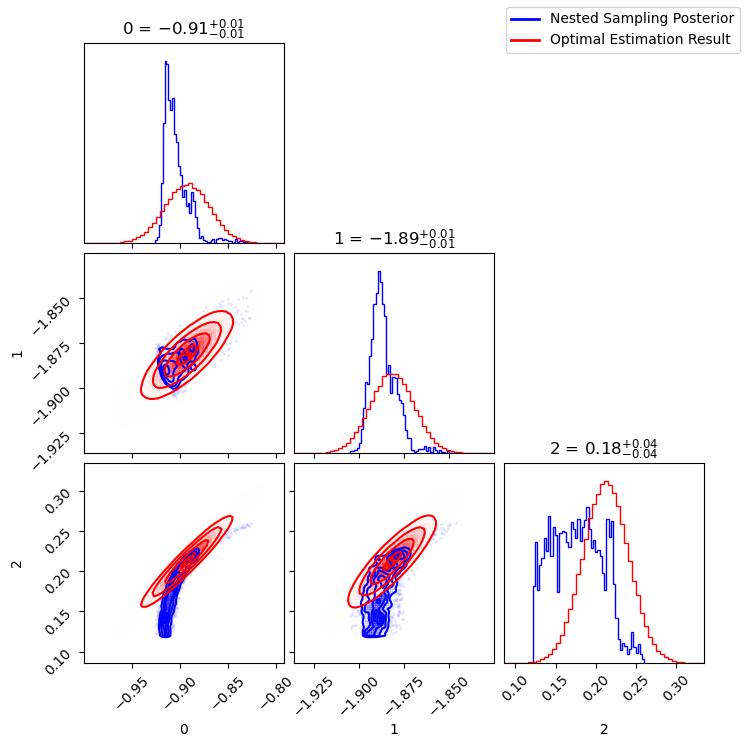

In [12]:
NestedSampling.compare()

We can see that both methods converge to the same value (within error), and the posterior distributions look fairly similar. However, this is a very simplified example - often the two methods do not agree so much!